# Credit Card Fraud Detection

**Overview**: Financial losses caused by credit card fraudulent activities amount to tens of billions of dollars globally. Currently, no definite taxonomy on credit card fraud types exists, though certain patterns are known to occur more frequently than others. We will use the model for fraud detection using Logistic Regression, Decision Trees, Random Forest and Support Vector Machines (SVM).   



### Getting Started

Currently, there are very limited datasets on Kaggle that shares credit card transactions, though it is masked to protect personal information. To overcome this limitation, Transaction Data Simulator (https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/SimulatedDataset.html) was used to generate dummy customers and their transactions. Fraud data was added for three scenarios:

1. **Scenario 1:** Any transaction with an amount greater than 220 is considered fraudulent.
2. **Scenario 2:** Every day, a list of two terminals is drawn at random. All transactions on these terminals over the next 28 days will be marked as fraudulent.
3. **Scenario 3:** Every day, a list of three customers is drawn at random. In the next 14 days, one-third of their transactions will have their amounts multiplied by five and marked as fraudulent.

Scenario 3 will be used for card-not-present scenarios to apply modeling techniques to identify the fraud and compare it with actual fraud data. Card-not-present refers to the general category of frauds conducted remotely, either by mail, phone, or on the Internet, using only some of the information present on a card.


### Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Read in the Data

Use pandas to read in the dataset `all_transactions.csv` and assign to a meaningful variable name.

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [4]:
# Load the data
df = pd.read_csv('simulated-data-csv/all_transactions.csv', sep = ',')

In [6]:
df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,DATE
0,0,2020-04-01 00:07:56,2,316,146.00,476,0,0,0,2020-04-01
1,1,2020-04-01 00:30:05,360,584,92.74,1805,0,0,0,2020-04-01
2,2,2020-04-01 00:32:35,183,992,39.30,1955,0,0,0,2020-04-01
3,3,2020-04-01 00:43:59,382,283,15.35,2639,0,0,0,2020-04-01
4,4,2020-04-01 00:45:51,381,799,23.15,2751,0,0,0,2020-04-01


### Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
A payment card transaction consists of any amount paid to a merchant by a customer at a certain time. The six main features that summarise a transaction are:

The transaction ID: A unique identifier for the transaction

The date and time: Date and time at which the transaction occurs

The customer ID: The identifier for the customer. Each customer has a unique identifier

The terminal ID: The identifier for the merchant (or more precisely the terminal). Each terminal has a unique identifier

The transaction amount: The amount of the transaction.

The fraud label: A binary variable, with the value for a legitimate transaction, or the value for a fraudulent transaction.

These features are referred to as TRANSACTION_ID, TX_DATETIME, CUSTOMER_ID, TERMINAL_ID, TX_AMOUNT, and TX_FRAUD.
Output variable (desired target):

```



### Business Objective

Fraud detection in financial applications involves leveraging advanced analytics, machine learning algorithms, and collaboration across multiple stakeholders to identify and prevent fraudulent activities effectively. By implementing robust fraud detection systems and maintaining compliance with regulatory standards, financial institutions can mitigate the risks associated with fraudulent transactions and protect their assets and reputation. This project aims to contribute to the development of effective fraud detection mechanisms, ultimately supporting financial stability and security.

In [8]:
# Understanding the Features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173832 entries, 0 to 173831
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   TRANSACTION_ID     173832 non-null  int64  
 1   TX_DATETIME        173832 non-null  object 
 2   CUSTOMER_ID        173832 non-null  int64  
 3   TERMINAL_ID        173832 non-null  int64  
 4   TX_AMOUNT          173832 non-null  float64
 5   TX_TIME_SECONDS    173832 non-null  int64  
 6   TX_TIME_DAYS       173832 non-null  int64  
 7   TX_FRAUD           173832 non-null  int64  
 8   TX_FRAUD_SCENARIO  173832 non-null  int64  
 9   DATE               173832 non-null  object 
dtypes: float64(1), int64(7), object(2)
memory usage: 13.3+ MB


### Visualization

Understand the distribution of features and the presence of fraud in different scenarios.

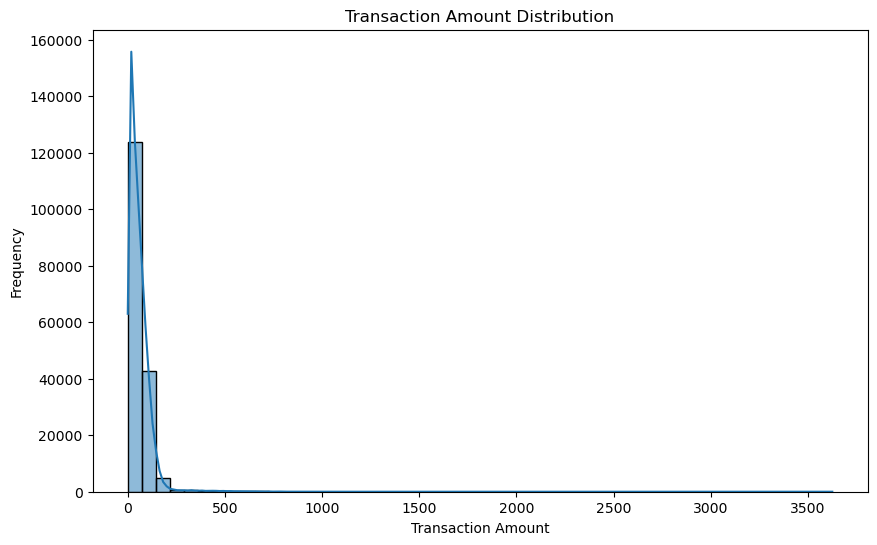

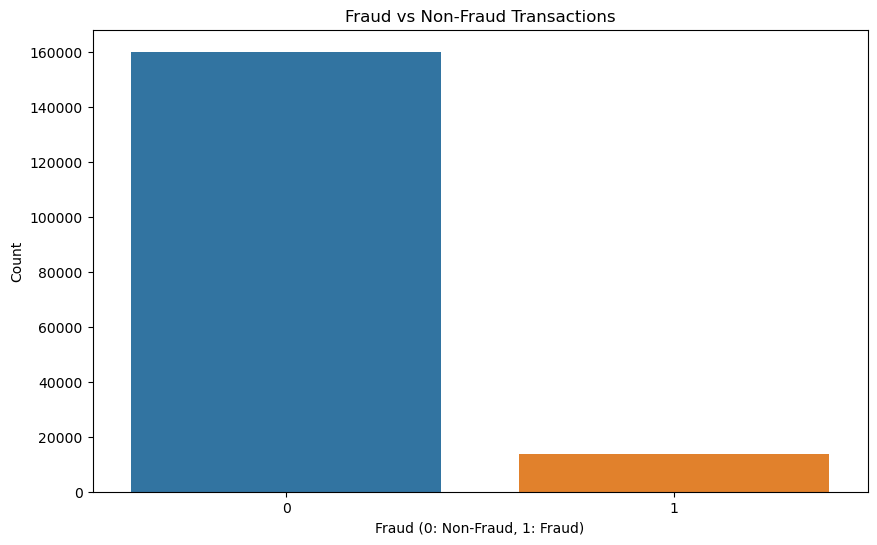

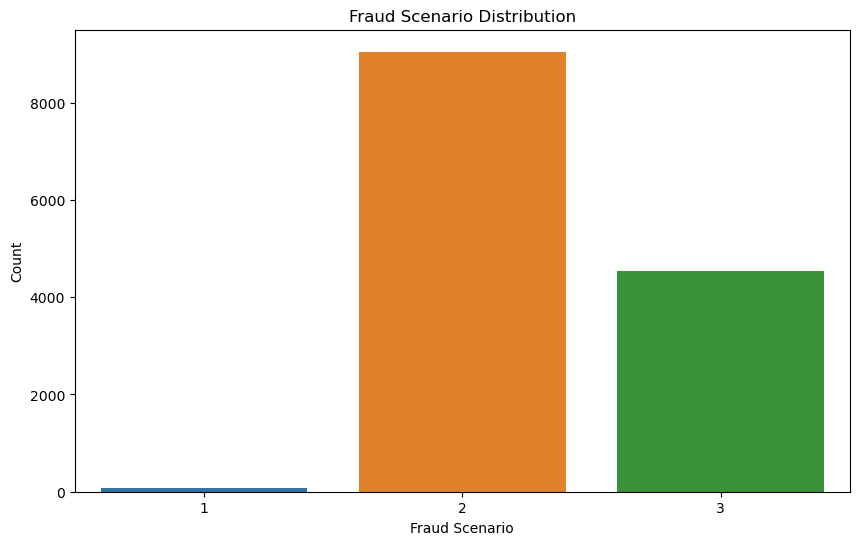

In [10]:
# Distribution of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(df['TX_AMOUNT'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

# Fraud distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='TX_FRAUD', data=df)
plt.title('Fraud vs Non-Fraud Transactions')
plt.xlabel('Fraud (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.show()

# Scenario 3 fraud distribution
df_scenario = df[df['TX_FRAUD_SCENARIO'] != 0]
plt.figure(figsize=(10, 6))
sns.countplot(x='TX_FRAUD_SCENARIO', data=df_scenario)
plt.title('Fraud Scenario Distribution')
plt.xlabel('Fraud Scenario')
plt.ylabel('Count')
plt.show()


### Engineering Features

Create features that will be useful for detecting fraud

In [12]:
# Engineering Features
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])
df['TX_DAY_OF_WEEK'] = df['TX_DATETIME'].dt.dayofweek
df['TX_HOUR'] = df['TX_DATETIME'].dt.hour
df['TX_MONTH'] = df['TX_DATETIME'].dt.month

# Adding a feature for the logarithm of the transaction amount
df['TX_AMOUNT_LOG'] = np.log1p(df['TX_AMOUNT'])

# Adding interaction terms
df['CUSTOMER_TERMINAL'] = df['CUSTOMER_ID'].astype(str) + '_' + df['TERMINAL_ID'].astype(str)


### Train/Test Split

With your data prepared, split it into a train and test set.

In [14]:
features = ['TX_AMOUNT', 'TX_DAY_OF_WEEK', 'TX_HOUR', 'TX_MONTH', 'TX_AMOUNT_LOG']
X = df[features]
y = df['TX_FRAUD']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

### Problem 9: Score the Model

What is the accuracy of your model?

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

##### Questions